In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [3]:

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)


In [4]:

################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 16
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [5]:
raw_data = scipy.io.loadmat('../datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

#batch_size = 10

#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
X_train.shape,y_train.shape

(torch.Size([8000, 128, 1]), torch.Size([8000, 256]))

In [6]:
X_test.shape,y_test.shape

(torch.Size([2000, 128, 1]), torch.Size([2000, 256]))

In [7]:
train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape

(torch.Size([128, 1]), torch.Size([256]))

In [8]:
test_loader.dataset[0][0].shape, test_loader.dataset[0][1].shape

(torch.Size([128, 1]), torch.Size([256]))

In [13]:
ntrain = 8000
ntest = 2000


In [10]:

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train_losses, test_losses = [], []

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        #print('in: ',x.shape)
        out = model(x)
        #print('out: ',out.shape)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    train_losses.append(train_l2)
    test_l2 /= ntest
    test_losses.append(test_l2)


    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})


549698
0 13.697290799987968 3.826727068144464e-05 0.18986112922430037 0.16855735445022582
1 8.209480900026392 1.8294202429274265e-05 0.14466062892973422 0.14185199445486069
2 8.11171219998505 1.6514663768134598e-05 0.13704217831790447 0.13704083719849586
3 8.2251584000187 1.539214894421548e-05 0.13210456984490157 0.12803907313942908
4 8.095038199971896 1.4882138320899686e-05 0.13000552174448968 0.12470890918374061
5 7.970145600032993 1.4186220172405228e-05 0.12671571732312442 0.12452027383446694
6 7.768745100009255 1.3801476764001563e-05 0.12494727930426598 0.12484308576583862
7 7.801986400038004 1.3474212084929605e-05 0.12341640069335699 0.12329395937919617
8 8.060661800031085 1.3181052841559903e-05 0.12213653600215912 0.11903270855545997
9 8.131456600036472 1.2762032241653287e-05 0.11975796611607074 0.12378824052214622
10 8.402459600009024 1.2519607385002018e-05 0.11876947359740735 0.11610901826620101
11 8.200581900018733 1.2168129328529176e-05 0.11697520181536675 0.11650291353464126

In [43]:
net = NeuralNetClassifier(
    model,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

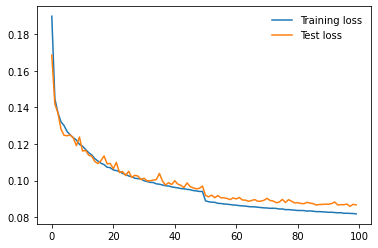

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

In [18]:
test_losses[-1]

0.08662327015399933

In [12]:
torch.save(model, 'fno_model.h5')

In [6]:
model = torch.load('fno_model.h5')

In [7]:
test_num = 434

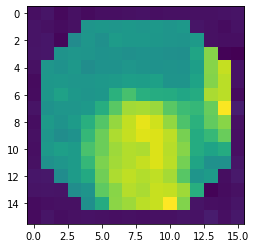

In [8]:
#Prediction
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
model.eval()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

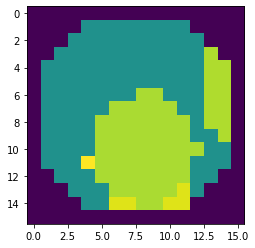

In [9]:
#Actual
acual_Out = test_loader.dataset[test_num][1]
out = np.reshape(acual_Out.numpy(),(16,16))
plt.imshow(out)

In [28]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [27]:
ssim_values = ssim(out, predicted, data_range=predicted.max() - predicted.min())
ssim_values

0.8948697036504746

In [30]:
psnr_values = psnr(out, predicted, data_range=predicted.max() - predicted.min())
psnr_values

24.041535142577256

In [10]:
diff_image = predicted - out
np.sqrt(np.sum(diff_image**2)/256)

0.003213705007029884

In [15]:
from sewar.full_ref import rmse, uqi

In [31]:
rms_values = []
psnr_values = []
ssim_values = []
uqi_values = []

for test_num in range(ntest):
    K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
    model.eval()
    predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

    truth = test_loader.dataset[test_num][1]
    truth_np = np.reshape(truth.numpy(),(16,16))

    #diff_image = predicted - truth_np
    #np.sqrt(np.sum(diff_image**2)/256)

    rms_values.append(rmse(predicted_np, truth_np))
    psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
    ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
    uqi_values.append(uqi(predicted_np, truth_np))

In [32]:
print("RMSE: ", sum(rms_values)/ len(rms_values))
print("PSNR: ", sum(psnr_values)/ len(psnr_values))
print("SSIM: ", sum(ssim_values)/ len(ssim_values))
print("UQI: ", sum(uqi_values)/ len(uqi_values))

RMSE:  0.0023541291470087363
PSNR:  27.468521709166044
SSIM:  0.9153840425265811
UQI:  0.9956912685207058


In [42]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier


In [44]:
batch_size = [10, 50, 100, 200]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=net, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.